# Afrikaans Keyboard Layout Optimisation

**Author:** Adesh Maharaj  
**Date:** August 2025  

This notebook applies the same optimisation pipeline described in the English notebook to the **Afrikaans corpus (100k sentences from Tatoeba)**.  

The English notebook contains detailed annotations explaining the methodology, genetic algorithm setup, and evaluation process.  
To prevent redundancy, this notebook contains lighter commentary, focusing on the application of the same pipeline to Afrikaans text.  

---

In [ ]:
from characters_placement import CharactersPlacement
from character import Character
from button import Button
from location import Location
from size import Size
from metrics_collector import MetricsCollector
import math
import numpy as np
import pprint

In [ ]:
# --- 1. Define character sets ---
FIXED_CHARACTERS = list("1234567890")  # Fixed numbers (IDs 0–9)
BASE_LETTERS = list("abcdefghijklmnopqrstuvwxyz") # 26 base letters
ACCENT_LETTERS = list("áéèêëîïíôóùûý") # Common accented letters in Afrikaans
PUNCTUATION_CHARS = list(".,;:!?'\"-=@#+<>[]$%^&*_|/") # Common punctuation used in Afrikaans
MUTABLE_CHARACTERS = BASE_LETTERS + ACCENT_LETTERS + PUNCTUATION_CHARS
CHARACTER_SET = FIXED_CHARACTERS + MUTABLE_CHARACTERS

CHARACTER_SET = list(sorted(set(CHARACTER_SET)))  # remove any accidental duplicates
print(f"Full character pool size: {len(CHARACTER_SET)}")
valid_chars = set(CHARACTER_SET)


# --- 2. Define key positions ---
NUMBER_ROW = [(i, -1) for i in range(12)]  # 12 keys: 1-0 plus two extra keys
TOP_ROW = [(i, 0) for i in range(12)]      # QWERTY top row (11)
HOME_ROW = [(i + 0.5, 1) for i in range(11)]  # home row (10)
BOTTOM_ROW = [(i + 1, 2) for i in range(10)]  # bottom row (10)

KEYBOARD_POSITIONS = NUMBER_ROW + TOP_ROW + HOME_ROW + BOTTOM_ROW

# --- 3. Build Button objects ---
buttons = []
for idx, (x, y) in enumerate(KEYBOARD_POSITIONS):
    buttons.append(Button(
        id=idx,
        location={'x': x, 'y': y},
        size={'width': 1.0, 'height': 1.0}
    ))

# --- 4. Create QWERTY layout ---
QWERTY_CHARS = FIXED_CHARACTERS + list("-=" + "qwertyuiop[]asdfghjkl;'" + "zxcvbnm,./")
assert len(QWERTY_CHARS) == len(buttons)

qwerty_layout = CharactersPlacement([
    {'character': ch, 'button_id': i}
    for i, ch in enumerate(QWERTY_CHARS)
])
print("QWERTY layout loaded into CharactersPlacement.")

Full character pool size: 74
QWERTY layout loaded into CharactersPlacement.


/tmp/ipython-input-3605656486.py:13: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(Rectangle((x, y), w, h, fill=True, color="#d3d3d3", edgecolor='black'))


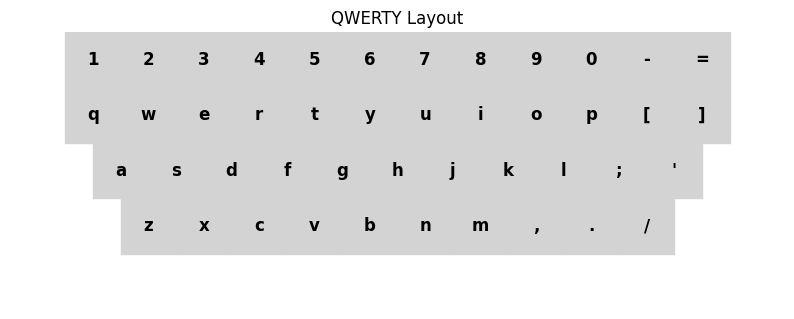

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def visualize_keyboard(layout, buttons, title="Keyboard Layout"):
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.set_aspect('equal')

    for char_obj in layout.characters_set:
        btn = buttons[char_obj.button_id]
        x, y = btn.location.x, btn.location.y
        w, h = btn.size.width, btn.size.height

        ax.add_patch(Rectangle((x, y), w, h, fill=True, color="#d3d3d3", edgecolor='black'))
        ax.text(x + w/2, y + h/2, char_obj.character,
                ha='center', va='center', fontsize=12, fontweight='bold')

    ax.set_xlim(-1, 13)
    ax.set_ylim(-1, 4)
    ax.invert_yaxis()
    ax.axis('off')
    plt.title(title)
    plt.show()

# Example usage:
visualize_keyboard(qwerty_layout, buttons, title="QWERTY Layout")

In [ ]:
import re
from collections import Counter

VALID_CHARS = set(CHARACTER_SET)

def load_and_extract_bigrams_from_txt(txt_path, valid_chars=None):
    with open(txt_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    # Remove line numbers like "1 This is a sentence"
    cleaned_lines = [re.sub(r'^\s*\d+\s+', '', line).lower() for line in lines]
    text_data = ''.join(cleaned_lines)

    # Keep only valid characters
    if valid_chars:
        text_data = ''.join([c for c in text_data if c in valid_chars])
    else:
        text_data = re.sub(r'[^a-z]', '', text_data)

    bigrams = [text_data[i:i+2] for i in range(len(text_data) - 1)]
    bigrams = [bg for bg in bigrams if len(bg) == 2]

    bigram_counts = Counter(bigrams)
    total = sum(bigram_counts.values())
    bigram_freq = {bg: count / total for bg, count in bigram_counts.items()}

    print(f"Loaded {len(bigram_freq)} unique bigrams from corpus.")
    return bigram_freq

def compute_char_freq_from_bigrams(bigram_freq):
    char_freq = Counter()
    for (a, b), prob in bigram_freq.items():
        char_freq[a] += prob / 2
        char_freq[b] += prob / 2
    return dict(char_freq)


In [ ]:
bigram_freq = load_and_extract_bigrams_from_txt("afr_mixed_2019_100K-sentences.txt", valid_chars=VALID_CHARS)
char_freq = compute_char_freq_from_bigrams(bigram_freq)

# Show most common bigrams and characters for prompting
top_12_bigrams = sorted(bigram_freq.items(), key=lambda x: x[1], reverse=True)[:12]
top_12_chars = sorted(char_freq.items(), key=lambda x: x[1], reverse=True)[:12]

print("\nTop 12 bigrams:")
for bg, freq in top_12_bigrams:
    print(f"{bg}: {freq:.4f}")

print("\nTop 12 characters:")
for ch, freq in top_12_chars:
    print(f"{ch}: {freq:.4f}")



Loaded 2928 unique bigrams from corpus.

Top 12 bigrams:
ie: 0.0306
er: 0.0251
di: 0.0217
en: 0.0198
an: 0.0189
aa: 0.0154
te: 0.0148
nd: 0.0140
in: 0.0137
ee: 0.0133
es: 0.0132
ge: 0.0130

Top 12 characters:
e: 0.1643
a: 0.0797
i: 0.0791
n: 0.0765
s: 0.0632
r: 0.0625
o: 0.0620
d: 0.0536
t: 0.0529
l: 0.0388
k: 0.0334
g: 0.0324


In [ ]:
from collections import defaultdict

def build_finger_map(buttons):
    """
    Maps each button ID to a finger ID based on x-position.
    Finger IDs: 0–4 left hand, 5–9 right hand.
    """
    finger_map = {}
    for btn in buttons:
        x = btn.location.x
        id = btn.id
        # Simplified 10-finger mapping based on x position
        if x <= 1:
            finger_map[id] = 0  # Left pinky
        elif x <= 2:
            finger_map[id] = 1  # Left ring
        elif x <= 3:
            finger_map[id] = 2  # Left middle
        elif x <= 4:
            finger_map[id] = 3  # Left index
        elif x <= 5:
            finger_map[id] = 4  # Left index (shared zone)
        elif x <= 6:
            finger_map[id] = 5  # Right index (shared zone)
        elif x <= 7:
            finger_map[id] = 6  # Right index
        elif x <= 8:
            finger_map[id] = 7  # Right middle
        elif x <= 9:
            finger_map[id] = 8  # Right ring
        else:
            finger_map[id] = 9  # Right pinky
    return finger_map

FINGER_STRAIN_WEIGHT = {
    0: 1.2,  # Left pinky
    1: 1.0,  # Left ring
    2: 0.8,  # Left middle
    3: 0.6,  # Left index
    4: 0.5,  # Shared
    5: 0.5,  # Shared
    6: 0.6,  # Right index
    7: 0.8,  # Right middle
    8: 1.0,  # Right ring
    9: 1.2   # Right pinky
}

def compute_finger_penalty(layout, char_freq, finger_map):
    finger_load = defaultdict(float)
    for ch_obj in layout.characters_set:
        ch = ch_obj.character
        if ch in char_freq:
            finger = finger_map.get(ch_obj.button_id)
            finger_load[finger] += char_freq[ch]

    finger_penalty = sum(
        load * FINGER_STRAIN_WEIGHT.get(finger, 1.0)
        for finger, load in finger_load.items()
    )
    return finger_penalty


In [ ]:
def compute_carpalx_fitness(layout, buttons, bigram_freq, char_freq=None,
                             home_row_indices=None, return_components=False):
    dist_weight = 0.5
    ROW_WEIGHT = {-1: 3.0, 0: 2, 1: 1.0, 2: 2.5}

    # --- positions and finger map (same as your EN/FR code) ---
    char_pos = {c.character: buttons[c.button_id] for c in layout.characters_set}
    finger_map = build_finger_map(buttons)
    char_to_finger = {c.character: finger_map[c.button_id] for c in layout.characters_set}

    base_cost = alternation_bonus = same_finger_penalty = 0.0
    row_penalty = home_row_bonus = 0.0
    missing = 0

    for (a, b), p in bigram_freq.items():
        if a not in char_pos or b not in char_pos:
            missing += 1
            continue
        ba, bb = char_pos[a], char_pos[b]
        xa, ya = ba.location.x, ba.location.y
        xb, yb = bb.location.x, bb.location.y

        dist = math.hypot(xa - xb, ya - yb)
        avg_row_pen = 0.5*(ROW_WEIGHT.get(int(round(ya)),1.0) + ROW_WEIGHT.get(int(round(yb)),1.0))
        base_cost += p * dist_weight * dist * avg_row_pen

        if (xa < 5) != (xb < 5):
            alternation_bonus += 0.3 * p
        if char_to_finger.get(a) == char_to_finger.get(b):
            same_finger_penalty += 0.6 * p  # (match the weight you’re using elsewhere)

    if char_freq and home_row_indices:
        for idx, c in enumerate(layout.characters_set):
            ch = c.character
            if ch in char_freq:
                if idx in home_row_indices:
                    home_row_bonus += 1.2 * char_freq[ch]
                y = int(round(buttons[c.button_id].location.y))
                ROW_WEIGHT_y = ROW_WEIGHT.get(y, 1.0)
                row_penalty += 0.1 * char_freq[ch] * ROW_WEIGHT_y

    SYMBOLS = set("[]{}()<>/\\|@#$%^&*_+=~`")
    symbol_penalty = 0.0
    if home_row_indices:
        for idx in home_row_indices:
            ch = layout.characters_set[idx].character
            if ch in SYMBOLS:
                symbol_penalty += 0.6

    finger_penalty = compute_finger_penalty(layout, char_freq, finger_map)

    final_score = (-base_cost + alternation_bonus - same_finger_penalty +
                   home_row_bonus - row_penalty - symbol_penalty - finger_penalty)

    if return_components:
        return final_score, missing, {
            "base_cost": base_cost,
            "alternation_bonus": alternation_bonus,
            "same_finger_penalty": same_finger_penalty,
            "home_row_bonus": home_row_bonus,
            "row_penalty": row_penalty,
            "symbol_penalty": symbol_penalty,
            "finger_penalty": finger_penalty,
        }
    return final_score, missing


In [ ]:
def get_home_row_indices(layout, buttons):
    for char_obj in layout.characters_set:
        assert 0 <= char_obj.button_id < len(buttons), (
            f"Invalid button_id {char_obj.button_id} (buttons only has {len(buttons)} entries)"
        )
    return [
        idx for idx, char_obj in enumerate(layout.characters_set)
        if round(buttons[char_obj.button_id].location.y) == 1
    ]


char_freq = Counter()  # optional: compute from corpus

# simple char freq from bigrams
for bg, p in bigram_freq.items():
    char_freq[bg[0]] += p
    char_freq[bg[1]] += p

def compute_layout_coverage(layout, bigram_freq):
    layout_chars = {ch.character for ch in layout.characters_set}

    total_bigrams = len(bigram_freq)
    typable_bigrams = sum(
        1 for bg in bigram_freq if bg[0] in layout_chars and bg[1] in layout_chars
    )

    return typable_bigrams / total_bigrams if total_bigrams else 0

for name, layout in [("QWERTY", qwerty_layout)]:
    home_row_indices = get_home_row_indices(layout, buttons)

    layout_chars = {ch.character for ch in layout.characters_set}
    filtered_bigrams = {
        bg: p for bg, p in bigram_freq.items() if bg[0] in layout_chars and bg[1] in layout_chars
    }

    score, _ = compute_carpalx_fitness(layout, buttons, filtered_bigrams, char_freq, home_row_indices)
    coverage = compute_layout_coverage(layout, bigram_freq)

    print(f"{name} → Fitness: {score:.4f} | Coverage: {coverage:.2%}")

for name, layout in [("QWERTY", qwerty_layout)]:
    home_row_indices = get_home_row_indices(layout, buttons)
    score, missing = compute_carpalx_fitness(layout, buttons, bigram_freq, char_freq, home_row_indices)
    print(f"{name} Scores → {score:.4f} Missing → {missing:.4f}")


QWERTY → Fitness: -3.9591 | Coverage: 58.09%
QWERTY Scores → -3.9591 Missing → 1227.0000


In [ ]:
def summarize_layout(layout, buttons, bigram_freq, char_freq, name="Layout",
                     home_row_indices=None):
    try:
        score, missing, comp = compute_carpalx_fitness(
            layout, buttons, bigram_freq, char_freq,
            home_row_indices=home_row_indices, return_components=True
        )
        components = {k: float(comp.get(k, 0.0)) for k in (
            "base_cost","alternation_bonus","same_finger_penalty",
            "home_row_bonus","row_penalty","symbol_penalty","finger_penalty")}
    except TypeError:
        score, missing = compute_carpalx_fitness(
            layout, buttons, bigram_freq, char_freq,
            home_row_indices=home_row_indices
        )
        components = {}

    total_types = max(1, len(bigram_freq))
    coverage_pct = 100.0 * (1.0 - float(missing) / total_types)

    char_to_btn = {o.character: buttons[o.button_id]
                   for o in getattr(layout, "characters_set", [])}
    def infer_finger(btn):
        if hasattr(btn, "finger") and btn.finger: return str(btn.finger)
        x = getattr(getattr(btn, "location", None), "x", None)
        if x is None: return "?"
        if x < 5: return "L1" if x>=4 else "L2" if x>=3 else "L3" if x>=2 else "L4" if x>=1 else "L5"
        return "R1" if x<6 else "R2" if x<7 else "R3" if x<8 else "R4" if x<9 else "R5"

    sfb_w = tot_w = 0.0
    for (a,b), w in bigram_freq.items():
        ba, bb = char_to_btn.get(a), char_to_btn.get(b)
        if ba is None or bb is None: continue
        tot_w += w
        if infer_finger(ba) == infer_finger(bb): sfb_w += w
    sfb_pct = (sfb_w/tot_w*100.0) if tot_w>0 else 0.0

    out = {"layout": name, "fitness": float(score), "coverage": coverage_pct,
           "same_finger_pct": sfb_pct, **components}
    out["missing_bigrams"] = int(missing)
    return out


In [ ]:
import pandas as pd

rows = []
rows.append(summarize_layout(qwerty_layout,   buttons, bigram_freq, char_freq, "QWERTY",
                             home_row_indices=get_home_row_indices(qwerty_layout, buttons)))
#rows.append(summarize_layout(layout,          buttons, bigram_freq, char_freq, "Afrikaans-GA",
#                             home_row_indices=get_home_row_indices(layout, buttons)))
pd.DataFrame(rows)
q = summarize_layout(
    qwerty_layout,
    buttons,
    bigram_freq,
    char_freq,
    name="QWERTY",
    home_row_indices=get_home_row_indices(qwerty_layout, buttons),
)
pprint.pprint(q)


{'alternation_bonus': 0.14605754637197293,
 'base_cost': 2.8742310756771396,
 'coverage': 58.09426229508197,
 'finger_penalty': 1.611517519498089,
 'fitness': -3.9590875318215635,
 'home_row_bonus': 0.8012847838840083,
 'layout': 'QWERTY',
 'missing_bigrams': 1227,
 'row_penalty': 0.34929326345764294,
 'same_finger_pct': 10.79936973657222,
 'same_finger_penalty': 0.07138800344467296,
 'symbol_penalty': 0.0}


In [ ]:
# Get top 35 most frequent characters from the corpus
from collections import Counter
import random

# Get top characters excluding fixed ones (like numbers)
top_n = 45
def get_top_characters(char_freq, top_n):
    sorted_chars = [char for char, _ in Counter(char_freq).most_common(top_n)]
    return [ch for ch in sorted_chars if ch not in FIXED_CHARACTERS]


# Here we take top_n numebr of the top characters to create some diversity if needed
#top_chars_pool = list({char for char, _ in Counter(char_freq).most_common(top_n)})

top_chars_pool = [
    char for char, _ in Counter(char_freq).most_common(top_n)
    if char not in FIXED_CHARACTERS
]

def create_random_genome():
    import random
    total_needed = len(buttons)  # Must match number of keys
    genome = FIXED_CHARACTERS[:]

    # Ensure we don’t pick duplicates
    mutable_pool = list(set(top_chars_pool) - set(FIXED_CHARACTERS))
    mutable_count = total_needed - len(FIXED_CHARACTERS)

    if mutable_count > len(mutable_pool):
        raise ValueError(f"Not enough unique characters to fill {mutable_count} mutable slots.")

    mutable = random.sample(mutable_pool, mutable_count)
    random.shuffle(mutable)

    return genome + mutable

In [ ]:
print("Len buttons:", len(buttons))
print("Max button_id in layout:", max(c.button_id for c in layout.characters_set))


Len buttons: 45
Max button_id in layout: 44


In [ ]:
# 1) Build the pool from most-common chars, excluding FIXED_CHARACTERS
top_chars_pool = [
    ch for ch, _ in Counter(char_freq).most_common(top_n)
    if ch not in FIXED_CHARACTERS
]

# 2) Sanity checks
assert len(buttons) == 45, f"Expected 45 buttons, got {len(buttons)}"
assert len(FIXED_CHARACTERS) == 10, f"Expected 10 fixed chars, got {len(FIXED_CHARACTERS)}"

# 3) Precompute mutable pool once (unique, excludes fixed)
MUTABLE_POOL = list(set(top_chars_pool) - set(FIXED_CHARACTERS))
MUTABLE_SLOTS = len(buttons) - len(FIXED_CHARACTERS)  # 45 - 10 = 35
if MUTABLE_SLOTS > len(MUTABLE_POOL):
    raise ValueError(
        f"Not enough unique characters to fill {MUTABLE_SLOTS} mutable slots; "
        f"have only {len(MUTABLE_POOL)} in MUTABLE_POOL. Increase top_n or adjust pools."
    )

def create_random_genome():
    """
    Create a 45-length genome:
      - first 10 positions: FIXED_CHARACTERS (in the given order)
      - remaining 35 positions: random permutation sampled from MUTABLE_POOL
    Uses global RNG seeded in Cell 1.
    """
    total_needed = len(buttons)          # 45
    genome = FIXED_CHARACTERS[:]         # fixed first 10

    # sample without replacement for the remaining 35
    mutable = random.sample(MUTABLE_POOL, MUTABLE_SLOTS)
    random.shuffle(mutable)

    genome += mutable

    # final sanity checks
    assert len(genome) == total_needed
    # no duplicates across fixed + mutable
    assert len(set(genome)) == len(genome), "Duplicate characters in genome!"
    return genome

In [ ]:
# CharactersPlacement and Button. This function wraps the conversion:
def genome_to_layout(genome):
    """
    Converts a genome (list of 45 characters) to a CharactersPlacement layout object.
    """
    return CharactersPlacement([
        {'character': ch, 'button_id': i}
        for i, ch in enumerate(genome[:len(buttons)])  # ✅ limit to button count
    ])

# Evaluates the genome
def evaluate_genome(genome, buttons, bigram_freq, char_freq):
    layout = genome_to_layout(genome)
    home_row_indices = get_home_row_indices(layout, buttons)

    score, missing, comp = compute_carpalx_fitness(
        layout, buttons, bigram_freq, char_freq,
        home_row_indices=home_row_indices, return_components=True
    )
    return score, comp  # <- required for component plots



In [ ]:
def mutate_genome(genome, mutation_rate):
    """
    Randomly swap two mutable characters in the genome (excluding fixed characters).
    """
    genome = genome[:]  # copy
    if random.random() < mutation_rate:
        i, j = random.sample(range(10, len(genome)), 2)  # only mutable part
        genome[i], genome[j] = genome[j], genome[i]
    return genome


def order_crossover(parent1, parent2):
    """
    Order Crossover (OX) for permutations, keeping first 10 characters fixed.
    """
    start, end = sorted(random.sample(range(10, len(parent1)), 2))

    # Inherit slice from Parent 1
    child = [None] * len(parent1)
    child[start:end] = parent1[start:end]

    # Fill remaining from Parent 2 in order
    p2_filtered = [ch for ch in parent2 if ch not in child[start:end]]

    j = 0
    for i in range(len(parent1)):
        if i >= start and i < end:
            continue
        child[i] = p2_filtered[j]
        j += 1

    return child


In [ ]:
def create_initial_population(pop_size):
    population = []
    while len(population) < pop_size:
        genome = create_random_genome()
        layout = genome_to_layout(genome)
        coverage = compute_layout_coverage(layout, bigram_freq)
        if coverage > 0.5:
            population.append(genome)
    return population


def tournament_selection(population, fitnesses, k=3):
    selected = random.sample(list(zip(population, fitnesses)), k)
    selected.sort(key=lambda x: -x[1])  # Higher fitness is better
    return selected[0][0]  # Return best genome


In [ ]:
def run_ga(buttons, bigram_freq, char_freq, generations, pop_size, mutation_rate, random_seed, *, metrics=None):
    import random
    import numpy as np

    random.seed(random_seed)
    np.random.seed(random_seed)

    # metrics setup (Afrikaans GA is MAXimizing)
    if metrics is None:
        metrics = MetricsCollector(maximize=True)
    metrics.start_timer()

    def eval_with_details(g):
        out = evaluate_genome(g, buttons, bigram_freq, char_freq)
        # support: (fitness, breakdown) OR fitness only
        if isinstance(out, tuple) and len(out) == 2 and isinstance(out[1], dict):
            return float(out[0]), out[1]
        elif isinstance(out, dict):
            return float(out["fitness"]), out
        else:
            return float(out), None

    elites = {}
    population = create_initial_population(pop_size)
    fitnesses, details = zip(*(eval_with_details(g) for g in population))
    fitnesses, details = list(fitnesses), list(details)

    best_idx = max(range(len(population)), key=lambda i: fitnesses[i])
    best_genome, best_score = population[best_idx], fitnesses[best_idx]
    history = [best_score]

    # log gen 0
    metrics.record_generation(0, fitnesses)
    if details[best_idx]:
        metrics.generation_stats[-1].update({
            "best_base_cost":         details[best_idx].get("base_cost", 0.0),
            "best_alternation_bonus": details[best_idx].get("alternation_bonus", 0.0),
            "best_same_finger_penalty": details[best_idx].get("same_finger_penalty", 0.0),
            "best_home_row_bonus":    details[best_idx].get("home_row_bonus", 0.0),
            "best_row_penalty":       details[best_idx].get("row_penalty", 0.0),
            "best_symbol_penalty":    details[best_idx].get("symbol_penalty", 0.0),
            "best_finger_penalty":    details[best_idx].get("finger_penalty", 0.0),
            "avg_base_cost":          details[best_idx].get("base_cost", 0.0),
            "avg_alternation_bonus":  details[best_idx].get("alternation_bonus", 0.0),
            "avg_same_finger_penalty":details[best_idx].get("same_finger_penalty", 0.0),
            "avg_home_row_bonus":     details[best_idx].get("home_row_bonus", 0.0),
            "avg_row_penalty":        details[best_idx].get("row_penalty", 0.0),
            "avg_symbol_penalty":     details[best_idx].get("symbol_penalty", 0.0),
            "avg_finger_penalty":     details[best_idx].get("finger_penalty", 0.0),
        })

    print(f"Generation 1: Best Score = {best_score:.4f}")

    # evolve
    for gen in range(1, generations + 1):
        new_population = []
        for _ in range(pop_size):
            p1 = tournament_selection(population, fitnesses)
            p2 = tournament_selection(population, fitnesses)
            child = order_crossover(p1, p2)
            child = mutate_genome(child, mutation_rate)
            new_population.append(child)

        population = new_population
        fitnesses, details = zip(*(eval_with_details(g) for g in population))
        fitnesses, details = list(fitnesses), list(details)

        # best this gen
        best_idx = max(range(len(population)), key=lambda i: fitnesses[i])
        if fitnesses[best_idx] > best_score:
            best_score = fitnesses[best_idx]
            best_genome = population[best_idx]

        # keep elites
        for g, s in zip(population, fitnesses):
            k = tuple(g)
            if k not in elites or s > elites[k]:
                elites[k] = s

        history.append(best_score)
        print(f"Generation {gen+1}: Best Score = {best_score:.4f}")

        # log generation
        metrics.record_generation(gen, fitnesses)  # fills best/avg/worst
        best_det = details[best_idx]
        if best_det:
            metrics.generation_stats[-1].update({
                "best_base_cost":         best_det.get("base_cost", 0.0),
                "best_alternation_bonus": best_det.get("alternation_bonus", 0.0),
                "best_same_finger_penalty": best_det.get("same_finger_penalty", 0.0),
                "best_home_row_bonus":    best_det.get("home_row_bonus", 0.0),
                "best_row_penalty":       best_det.get("row_penalty", 0.0),
                "best_symbol_penalty":    best_det.get("symbol_penalty", 0.0),
                "best_finger_penalty":    best_det.get("finger_penalty", 0.0),
                "avg_base_cost":          best_det.get("base_cost", 0.0),
                "avg_alternation_bonus":  best_det.get("alternation_bonus", 0.0),
                "avg_same_finger_penalty":best_det.get("same_finger_penalty", 0.0),
                "avg_home_row_bonus":     best_det.get("home_row_bonus", 0.0),
                "avg_row_penalty":        best_det.get("row_penalty", 0.0),
                "avg_symbol_penalty":     best_det.get("symbol_penalty", 0.0),
                "avg_finger_penalty":     best_det.get("finger_penalty", 0.0),
            })

    top3 = sorted(elites.items(), key=lambda kv: kv[1], reverse=True)[:3]
    top3 = [(list(gen), score) for (gen, score) in top3]

    elapsed = metrics.stop_timer()
    df = metrics.to_dataframe()
    return best_genome, best_score, history, top3, df, elapsed


In [ ]:
# Make sure evaluate_genome returns (score, components_dict) so component plots work.
metrics = MetricsCollector(maximize=True)  # GA is maximizing here
# ensure finger map consistency for workload plots
metrics.finger_map = build_finger_map(buttons)

# --- Hyperparameters ---
RANDOM_SEED = 42
MUTATION_RATE = 0.1
POP_SIZE = 150
GENERATIONS = 200

# --- Set Seeds ---
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

best_genome, best_score, history, top3, df, elapsed = run_ga(
    buttons, bigram_freq, char_freq,
    generations=GENERATIONS, pop_size=POP_SIZE,
    mutation_rate=MUTATION_RATE, random_seed=RANDOM_SEED,
    metrics=metrics,
)



Generation 1: Best Score = -3.4719
Generation 2: Best Score = -2.7170
Generation 3: Best Score = -2.7170
Generation 4: Best Score = -2.7170
Generation 5: Best Score = -2.6680
Generation 6: Best Score = -2.6680
Generation 7: Best Score = -2.5878
Generation 8: Best Score = -2.3335
Generation 9: Best Score = -2.3335
Generation 10: Best Score = -2.3335
Generation 11: Best Score = -2.3158
Generation 12: Best Score = -2.2622
Generation 13: Best Score = -2.2622
Generation 14: Best Score = -2.2566
Generation 15: Best Score = -2.2523
Generation 16: Best Score = -2.1740
Generation 17: Best Score = -2.1495
Generation 18: Best Score = -2.1337
Generation 19: Best Score = -2.1337
Generation 20: Best Score = -2.0680
Generation 21: Best Score = -2.0680
Generation 22: Best Score = -1.9739
Generation 23: Best Score = -1.9739
Generation 24: Best Score = -1.9739
Generation 25: Best Score = -1.9739
Generation 26: Best Score = -1.9704
Generation 27: Best Score = -1.9704
Generation 28: Best Score = -1.9704
G

In [ ]:
# Plot Heatmap of Key Frequencies
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle


def plot_layout_heatmap(layout, buttons, char_freq, title="Key Frequency Heatmap"):
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.set_aspect('equal')

    max_freq = max(char_freq.get(c.character, 0) for c in layout.characters_set)

    for char_obj in layout.characters_set:
        btn = buttons[char_obj.button_id]
        x, y = btn.location.x, btn.location.y
        w, h = btn.size.width, btn.size.height
        freq = char_freq.get(char_obj.character, 0)
        intensity = freq / max_freq if max_freq > 0 else 0

        ax.add_patch(Rectangle((x, y), w, h, fill=True, color=plt.cm.viridis(intensity), edgecolor='black'))
        ax.text(x + w / 2, y + h / 2, char_obj.character,
                ha='center', va='center', fontsize=12, fontweight='bold', color='white')

    ax.set_xlim(-1, 13)
    ax.set_ylim(-1, 4)
    ax.invert_yaxis()
    ax.axis('off')
    plt.title(title)
    plt.show()


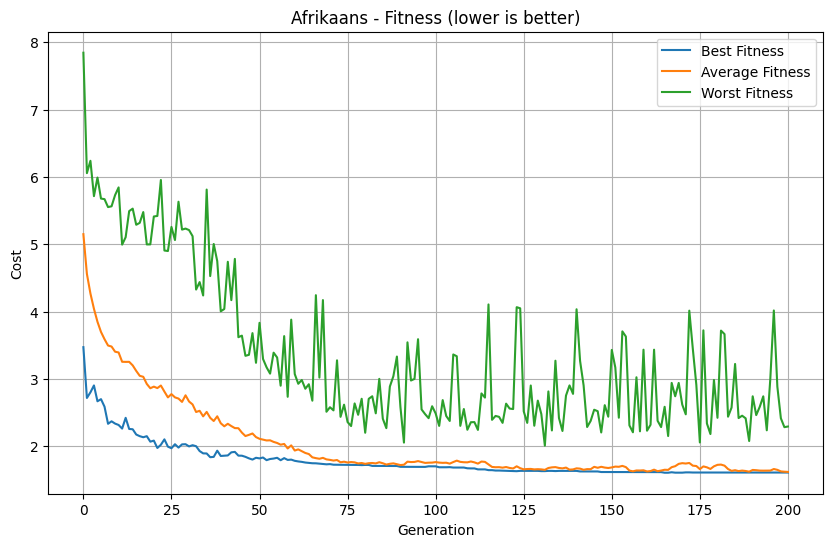

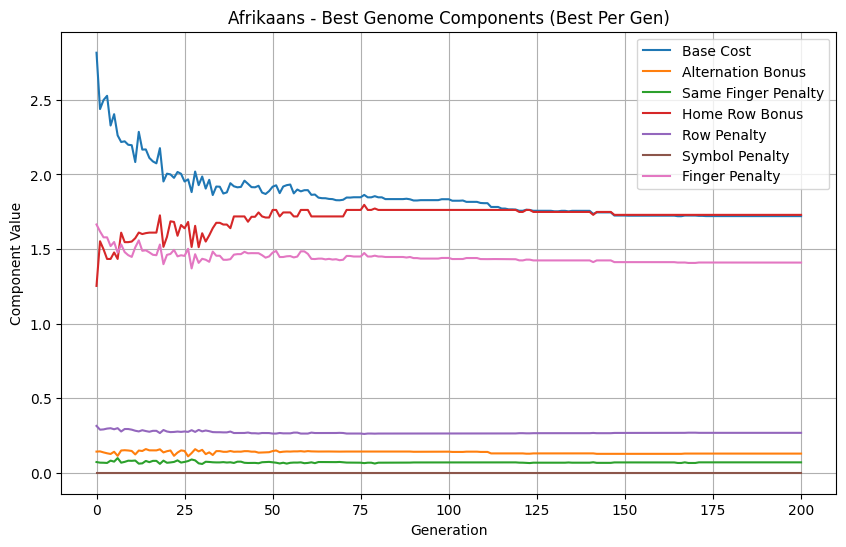

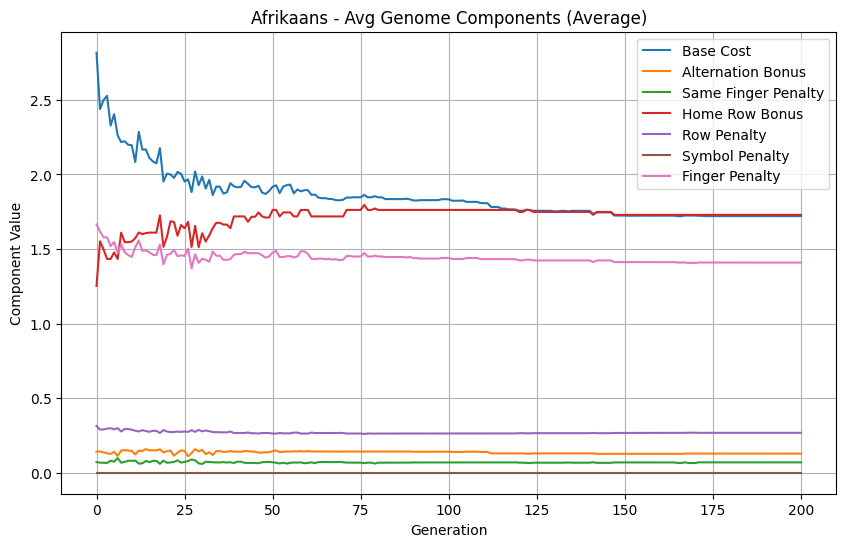

Afrikaans - Same-finger bigram total: 0


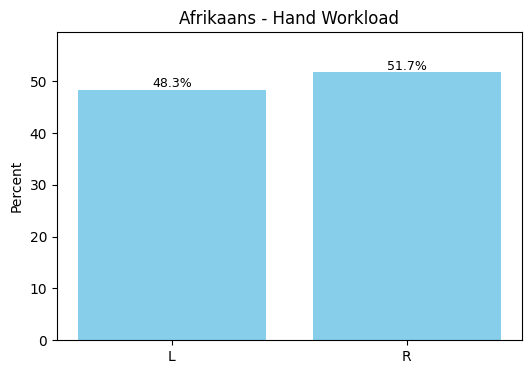

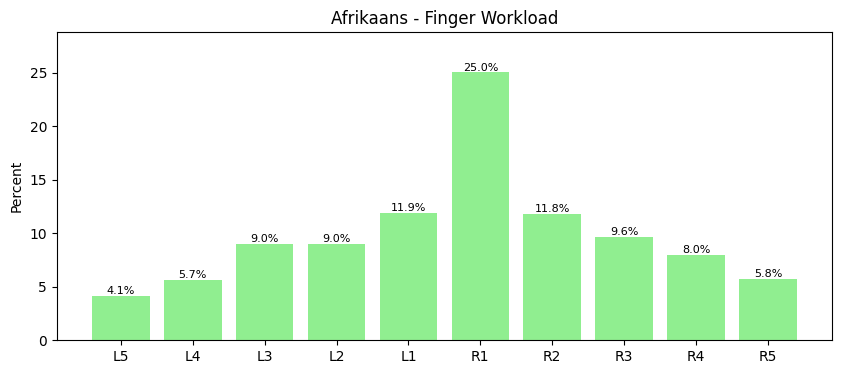

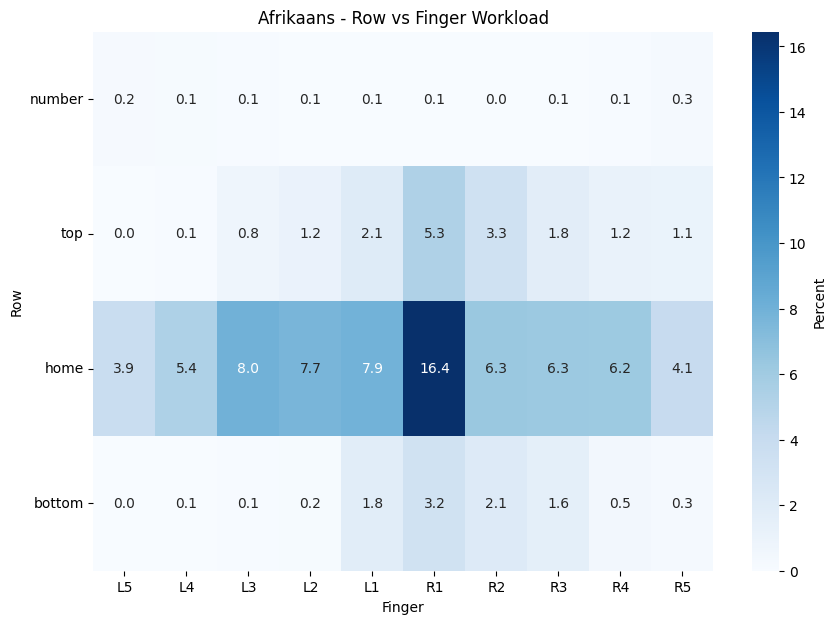

/tmp/ipython-input-1726982784.py:20: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(Rectangle((x, y), w, h, fill=True, color=plt.cm.viridis(intensity), edgecolor='black'))


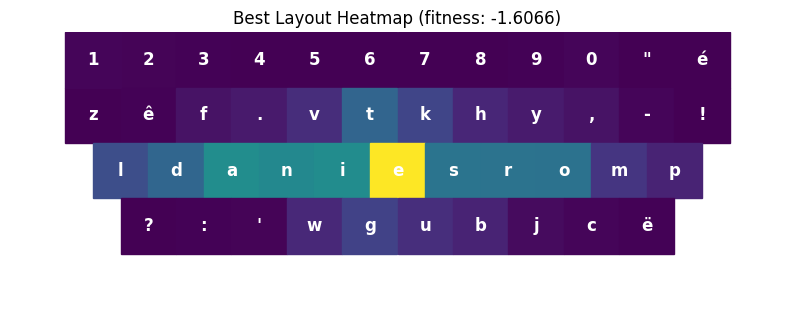

/tmp/ipython-input-3605656486.py:13: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(Rectangle((x, y), w, h, fill=True, color="#d3d3d3", edgecolor='black'))


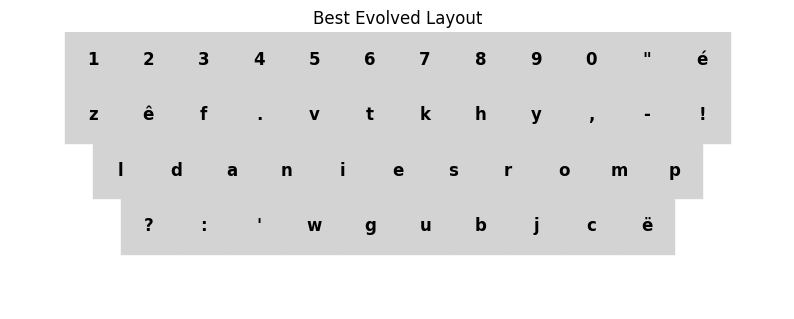

{'alternation_bonus': 0.12666369265158675,
 'base_cost': 1.7201676071541767,
 'coverage': 64.92486338797814,
 'finger_penalty': 1.4092935902167165,
 'fitness': -1.6065857432899708,
 'home_row_bonus': 1.729060745682945,
 'layout': 'BESTGA',
 'missing_bigrams': 1027,
 'row_penalty': 0.267459223337016,
 'same_finger_pct': 13.733642793624318,
 'same_finger_penalty': 0.06538976091659313,
 'symbol_penalty': 0.0}


In [ ]:
metrics.plot_fitness_curve(df, title="Afrikaans - Fitness (lower is better)", as_cost=True)
metrics.plot_component_curves(df, use_avg=False, title="Afrikaans - Best Genome Components")
metrics.plot_component_curves(df, use_avg=True,  title="Afrikaans - Avg Genome Components")

# Convert the best genome to a CharactersPlacement layout and visualize it
layout = genome_to_layout(best_genome)
buttons_map = buttons if hasattr(buttons, "values") else {i: b for i, b in enumerate(buttons)}
metrics.plot_final_best_layout(layout, buttons_map, char_freq, bigram_freq, run_label="Afrikaans")

plot_layout_heatmap(layout, buttons, char_freq, title= f"Best Layout Heatmap (fitness: {top3[0][1]:.4f})")

def visualize_best_layout(best_genome, buttons, title="Best Evolved Layout"):
    layout = genome_to_layout(best_genome)
    visualize_keyboard(layout, buttons, title)
    return layout

best_layout = visualize_best_layout(best_genome, buttons)

bGA = summarize_layout(
    layout,
    buttons,
    bigram_freq,
    char_freq,
    name="BESTGA",
    home_row_indices=get_home_row_indices(layout, buttons),
)
pprint.pprint(bGA)

C:\Users\adesh\AppData\Local\Temp\ipykernel_39788\420671390.py:13: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(Rectangle((x, y), w, h, fill=True, color="#d3d3d3", edgecolor='black'))


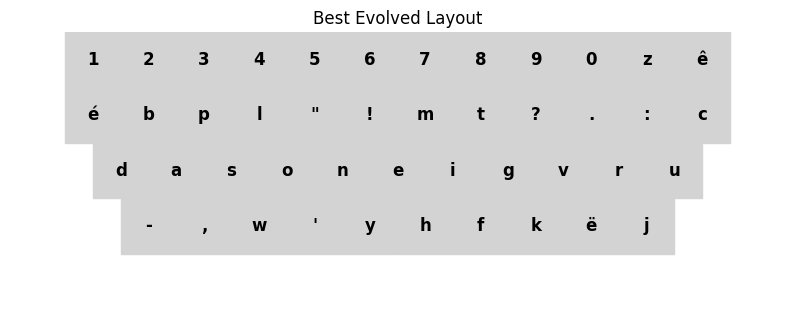

In [ ]:
def genome_to_layout_dict(genome):
    # indices: 0..11 num row, 12..23 top row, 24..34 home row, 35..44 bottom row
    tn = ''.join(genome[0:12])
    tr = ''.join(genome[12:24])
    hr = ''.join(genome[24:35])
    br = ''.join(genome[35:45])
    return {
        "top_number_row": tn,
        "top_row": tr,
        "home_row": hr,
        "bottom_row": br,
    }


Final Best Genome reevaluated: -1.6666

Top 1 score=-1.6666
{'top_number_row': '1234567890?z', 'top_row': '"cyfgltuj\'éë', 'home_row': 'hkroesanidv', 'bottom_row': '!:pbmw.,-ê'}
Top 2 score=-1.6672
{'top_number_row': '1234567890?z', 'top_row': '"cyfltguj\'éë', 'home_row': 'hkroesanidv', 'bottom_row': '!:pbmw.,-ê'}
Top 3 score=-1.6683
{'top_number_row': '1234567890?z', 'top_row': 'c"yfgltuj\'éë', 'home_row': 'hkroesanidv', 'bottom_row': '!-pbmw.,:ê'}
First chars: 45
best layout loaded.


C:\Users\adesh\AppData\Local\Temp\ipykernel_67968\1726982784.py:20: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(Rectangle((x, y), w, h, fill=True, color=plt.cm.viridis(intensity), edgecolor='black'))


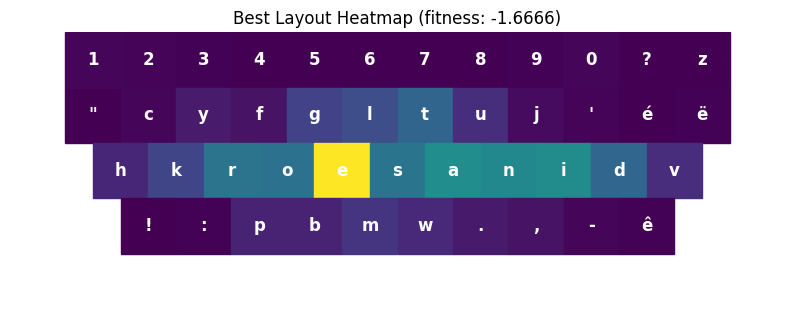

second best layout loaded.


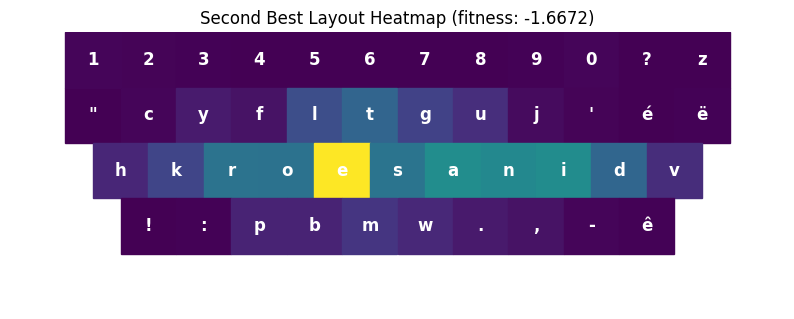

third best layout loaded.


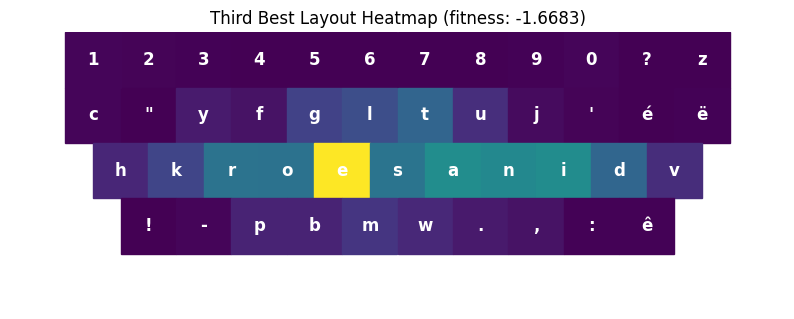

Best Layout → Fitness: -1.6666 | Coverage: 64.92%
First Best → Fitness: -1.6666 | Coverage: 64.92%
Second Best → Fitness: -1.6672 | Coverage: 64.92%
Third Best → Fitness: -1.6683 | Coverage: 64.92%


In [ ]:
final_score = evaluate_genome(best_genome, buttons, bigram_freq, char_freq)
print(f"Final Best Genome reevaluated: {final_score:.4f}\n")

for i, (gen, sc) in enumerate(top3, 1):
    layout = genome_to_layout_dict(gen)
    print(f"Top {i} score={sc:.4f}")
    print(layout)

first = "1234567890?z\"cyfgltuj\'éëhkroesanidv!:pbmw.,-ê"
second = "1234567890?z\"cyfltguj'éëhkroesanidv!:pbmw.,-ê"
third = "1234567890?zc\"yfgltuj'éëhkroesanidv!-pbmw.,:ê"

FIRST_CHARS = list(first)
print("First chars:", len(FIRST_CHARS))
SECOND_CHARS = list(second)
THIRD_CHARS = list(third)

assert len(FIRST_CHARS) == len(buttons)
first_layout = CharactersPlacement(
    [{"character": ch, "button_id": i} for i, ch in enumerate(FIRST_CHARS)]
)
print("best layout loaded.")
plot_layout_heatmap(first_layout, buttons, char_freq, title= f"Best Layout Heatmap (fitness: {top3[0][1]:.4f})")

assert len(SECOND_CHARS) == len(buttons)
second_layout = CharactersPlacement(
    [{"character": ch, "button_id": i} for i, ch in enumerate(SECOND_CHARS)]
)
print("second best layout loaded.")
plot_layout_heatmap(second_layout, buttons, char_freq, title= f"Second Best Layout Heatmap (fitness: {top3[1][1]:.4f})")

assert len(THIRD_CHARS) == len(buttons)
third_layout = CharactersPlacement(
    [{"character": ch, "button_id": i} for i, ch in enumerate(THIRD_CHARS)]
)
print("third best layout loaded.")
plot_layout_heatmap(third_layout, buttons, char_freq, title= f"Third Best Layout Heatmap (fitness: {top3[2][1]:.4f})")

for name, layout in [
    ("Best Layout", best_layout),
    ("First Best", first_layout),
    ("Second Best", second_layout),
    ("Third Best", third_layout),
]:
    home_row_indices = get_home_row_indices(layout, buttons)
    score, missing = compute_carpalx_fitness(
        layout, buttons, bigram_freq, char_freq, home_row_indices
    )
    coverage = compute_layout_coverage(layout, bigram_freq)
    print(f"{name} → Fitness: {score:.4f} | Coverage: {coverage:.2%}")

# LLM Setup

In [ ]:
from pathlib import Path
import os, csv, json, datetime
from pydantic import BaseModel, constr, ValidationError
from openai import OpenAI

client = OpenAI()

# --- Paths ---
PROMPT_DIR = Path("prompts")
IMG_DIR = Path("images")
LOG_PATH = Path("logs/api_runs_log.csv")
LOG_PATH.parent.mkdir(parents=True, exist_ok=True)

# --- Schema ---
Row12 = constr(min_length=12, max_length=12)
Row11 = constr(min_length=11, max_length=11)
Row10 = constr(min_length=10, max_length=10)

class KeyboardLayout(BaseModel):
    top_number_row: Row12
    top_row: Row12
    home_row: Row11
    bottom_row: Row10

ALLOWED = CHARACTER_SET

def validate_layout_dict(d: dict):
    try:
        tn, tr, hr, br = d["top_number_row"], d["top_row"], d["home_row"], d["bottom_row"]

        # Check row lengths
        if not (len(tn) == 12 and len(tr) == 12 and len(hr) == 11 and len(br) == 10):
            return False, "row length mismatch"

        # Check number row starts with 1234567890
        if tn[:10] != "1234567890":
            return False, "first 10 digits must be 1234567890"

        union = tn + tr + hr + br

        # Only check for duplicates
        duplicates = [ch for ch in set(union) if union.count(ch) > 1]
        if duplicates:
            return False, f"duplicate characters found: {duplicates} union: {union}"

        return True, ""

    except Exception as e:
        return False, str(e)


def layout_to_charlist(d: dict):
    return list(d["top_number_row"] + d["top_row"] + d["home_row"] + d["bottom_row"])

def score_layout(d: dict):
    # Uses notebook globals: CharactersPlacement, buttons, bigram_freq, char_freq, get_home_row_indices,
    # compute_carpalx_fitness, compute_layout_coverage
    chars = layout_to_charlist(d)
    layout_obj = CharactersPlacement([{"character": ch, "button_id": i} for i, ch in enumerate(chars)])
    home_row_indices = get_home_row_indices(layout_obj, buttons)
    score, _missing = compute_carpalx_fitness(layout_obj, buttons, bigram_freq, char_freq, home_row_indices)
    coverage = compute_layout_coverage(layout_obj, bigram_freq)
    return score, coverage

def ensure_log_header():
    if not LOG_PATH.exists():
        with open(LOG_PATH, "w", newline="", encoding="utf-8") as f:
            csv.writer(f).writerow([
                "timestamp","language","prompt_type","prompt_id",
                "temperature","seed","model",
                "valid","reason",
                "fitness","coverage",
                "top_number_row","top_row","home_row","bottom_row"
            ])

def log_row(language, ptype, pid, temp, seed, model, valid, reason, score, coverage, d):
    with open(LOG_PATH, "a", newline="", encoding="utf-8") as f:
        csv.writer(f).writerow([
            datetime.datetime.now().isoformat(timespec="seconds"),
            language, ptype, pid,
            temp, seed, model,
            valid, reason,
            f"{score:.4f}" if score is not None else "",
            f"{coverage:.2%}" if coverage is not None else "",
            d.get("top_number_row","") if d else "",
            d.get("top_row","") if d else "",
            d.get("home_row","") if d else "",
            d.get("bottom_row","") if d else "",
        ])

def load_prompt(code, ptype, pid):
    # Files like: EN_no_examples_1.txt, FR_with_examples_2.txt, AF_feedback_3.txt
    fname = f"{code}_{ptype}_{pid}.txt"
    return (PROMPT_DIR / fname).read_text(encoding="utf-8")

def lang_name(code):
    return {"EN":"English","FR":"French","AF":"Afrikaans"}[code]

ensure_log_header()


In [ ]:
def run_no_examples_grid(
    codes=("EN","FR","AF"),
    prompt_ids=(1,2,3),
    temps=(0.0, 0.2, 0.4),
    model="gpt-4.1",
    seed=None
):
    for code in codes:
        language = lang_name(code)
        for pid in prompt_ids:
            prompt_text = load_prompt(code, "no_examples", pid)
            for temp in temps:
                try:
                    resp = client.responses.parse(
                        model=model,
                        input=prompt_text,
                        text_format=KeyboardLayout,
                        temperature=temp,  # remove if unsupported
                        **({"seed": seed} if seed is not None else {})
                    )
                    d = resp.output_parsed.model_dump()
                    valid, reason = validate_layout_dict(d)
                    score, cov = (score_layout(d) if valid else (None, None))
                    log_row(language, "no_examples", pid, temp, seed, model, valid, reason, score, cov, d if valid else {})
                except ValidationError as e:
                    log_row(language, "no_examples", pid, temp, seed, model, False, f"Pydantic: {e}", None, None, {})
                except Exception as e:
                    log_row(language, "no_examples", pid, temp, seed, model, False, str(e), None, None, {})

# English no examples run
for i in range(30):
    print(f" Run {i+1}/30")
    run_no_examples_grid(codes=("AF",), temps=(0.0, 0.2, 0.4,))


 Run 1/30
 Run 2/30
 Run 3/30
 Run 4/30
 Run 5/30
 Run 6/30
 Run 7/30
 Run 8/30
 Run 9/30
 Run 10/30
 Run 11/30
 Run 12/30
 Run 13/30
 Run 14/30
 Run 15/30
 Run 16/30
 Run 17/30
 Run 18/30
 Run 19/30
 Run 20/30
 Run 21/30
 Run 22/30
 Run 23/30
 Run 24/30
 Run 25/30
 Run 26/30
 Run 27/30
 Run 28/30
 Run 29/30
 Run 30/30


In [ ]:
def run_with_examples_grid(
    codes=("EN","FR","AF"),
    prompt_ids=(1,2,3),
    temps=(0.0, 0.2, 0.4),   # temperature values
    model="gpt-4.1"
):
    for code in codes:
        language = lang_name(code)
        for pid in prompt_ids:
            prompt_text = load_prompt(code, "with_examples", pid)
            for temp in temps:
                try:
                    resp = client.responses.parse(
                        model=model,
                        input=prompt_text,
                        text_format=KeyboardLayout,
                        temperature=temp  # remove if SDK errors here
                    )
                    d = resp.output_parsed.model_dump()
                    valid, reason = validate_layout_dict(d)
                    score, cov = (score_layout(d) if valid else (None, None))
                    log_row(language, "with_examples", pid, temp, None, model, valid, reason, score, cov, d if valid else {})
                except ValidationError as e:
                    log_row(language, "with_examples", pid, temp, None, model, False, f"Pydantic: {e}", None, None, {})
                except Exception as e:
                    log_row(language, "with_examples", pid, temp, None, model, False, str(e), None, None, {})


# Afrikaans with examples run:
for i in range(30):
    print(f" Run {i+1}/30")
    run_with_examples_grid(codes=("AF",), temps=(0.0, 0.2, 0.4,))


 Run 1/30
 Run 2/30
 Run 3/30
 Run 4/30
 Run 5/30
 Run 6/30
 Run 7/30
 Run 8/30
 Run 9/30
 Run 10/30
 Run 11/30
 Run 12/30
 Run 13/30
 Run 14/30
 Run 15/30
 Run 16/30
 Run 17/30
 Run 18/30
 Run 19/30
 Run 20/30
 Run 21/30
 Run 22/30
 Run 23/30
 Run 24/30
 Run 25/30
 Run 26/30
 Run 27/30
 Run 28/30
 Run 29/30
 Run 30/30


In [ ]:
# --- Feedback test (same style as your other tests: responses.parse + Pydantic) ---

from pathlib import Path
from pydantic import ValidationError
import base64, mimetypes

PROMPT_DIR = Path("prompts")
IMG_DIR    = Path("images/feedback")

def load_feedback_prompt(code: str, pid: int) -> str:
    """
    Reads prompts/EN_feedback_1.txt (or FR/AF) and prepends a short JSON-only instruction
    so the model doesn't drift into prose. Your original text remains unchanged.
    """
    p = PROMPT_DIR / f"{code}_feedback_{pid}.txt"
    user_text = p.read_text(encoding="utf-8")
    json_only = (
        "Return ONLY a JSON object with keys: top_number_row, top_row, home_row, bottom_row. "
        "No prose or markdown. Each row is a single string with exact lengths (12,12,11,10). "
        "top_number_row must begin with '1234567890'.\n\n"
    )
    return json_only + user_text

def _to_data_url(path: Path) -> str:
    mime = mimetypes.guess_type(str(path))[0] or "image/png"
    b64  = base64.b64encode(path.read_bytes()).decode("ascii")
    return f"data:{mime};base64,{b64}"

def feedback_messages(prompt_text: str, heatmap_path: Path):
    """
    Build multimodal messages for 4o: text + image (as base64 data URL).
    """
    content = [{"type": "input_text", "text": prompt_text}]
    if heatmap_path and heatmap_path.exists():
        content.append({"type": "input_image", "image_url": _to_data_url(heatmap_path)})
    else:
        print(f"[warn] Heatmap not found: {heatmap_path}")
    return [{"role": "user", "content": content}]

def run_feedback_grid(
    codes=("AF",),
    prompt_ids=(1,2,3),      # matches EN_feedback_1/2/3.txt and EN_GA_1/2/3.png
    temps=(0.0, 0.2, 0.4),
    model="gpt-4.1"
):
    for code in codes:
        language = lang_name(code)
        for pid in prompt_ids:
            prompt_text  = load_feedback_prompt(code, pid)
            heatmap_path = IMG_DIR / f"{code}_GA_{pid}.png"   # e.g., images/feedback/EN_GA_1.png
            messages     = feedback_messages(prompt_text, heatmap_path)

            for temp in temps:
                try:
                    resp = client.responses.parse(
                        model=model,
                        input=messages,              # multimodal input, same as other tests style
                        text_format=KeyboardLayout,  # enforce schema
                        temperature=temp             # remove if your SDK complains
                    )
                    d = resp.output_parsed.model_dump()

                    valid, reason = validate_layout_dict(d)
                    score, cov = (score_layout(d) if valid else (None, None))

                    # seed is None for 4o runs; keep column for log consistency
                    log_row(language, "feedback", pid, temp, None, model,
                            valid, reason, score, cov, d if valid else {})

                except ValidationError as e:
                    log_row(language, "feedback", pid, temp, None, model,
                            False, f"Pydantic: {e}", None, None, {})
                except Exception as e:
                    log_row(language, "feedback", pid, temp, None, model,
                            False, str(e), None, None, {})


In [ ]:
for i in range(30):
    print(f" Run {i+1}/30")
    run_feedback_grid(codes=("AF",), temps=(0, 0.2, 0.4,))

 Run 1/30
 Run 2/30
 Run 3/30
 Run 4/30
 Run 5/30
 Run 6/30
 Run 7/30
 Run 8/30
 Run 9/30
 Run 10/30
 Run 11/30
 Run 12/30
 Run 13/30
 Run 14/30
 Run 15/30
 Run 16/30
 Run 17/30
 Run 18/30
 Run 19/30
 Run 20/30
 Run 21/30
 Run 22/30
 Run 23/30
 Run 24/30
 Run 25/30
 Run 26/30
 Run 27/30
 Run 28/30
 Run 29/30
 Run 30/30
